In [1]:
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


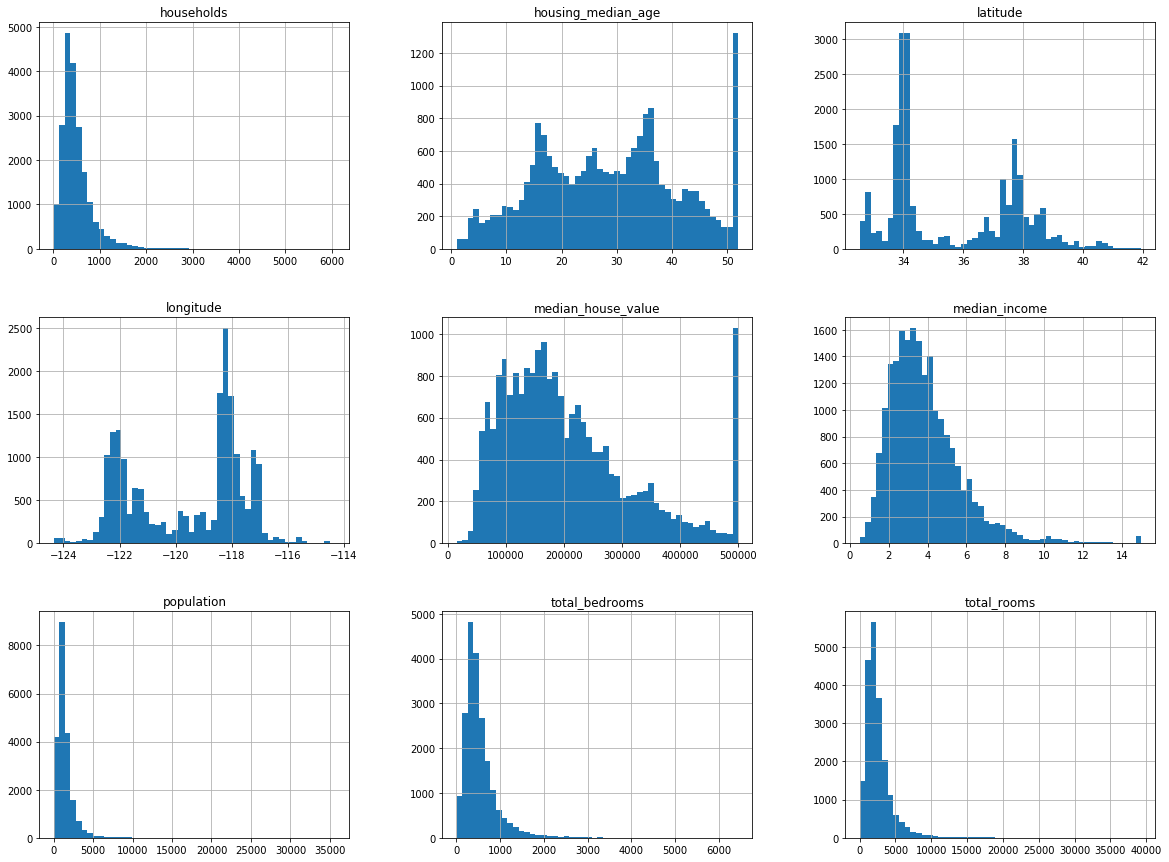

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [17]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [18]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [20]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [21]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [22]:
print(len(train_set))
print(len(test_set))

16512
4128


In [23]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set))
print(len(test_set))

16512
4128


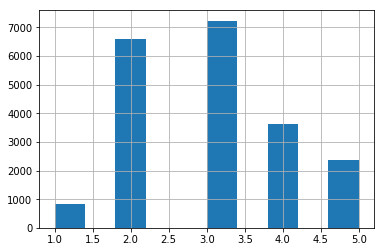

In [25]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    print('train_index, test_index:', train_index, test_index )
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

train_index, test_index: [17606 18632 14650 ... 13908 11159 15775] [ 5241 10970 20351 ...  4019 12107  2398]


In [31]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [33]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [34]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [35]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

/home/kuzman/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [38]:
housing = strat_train_set.copy()

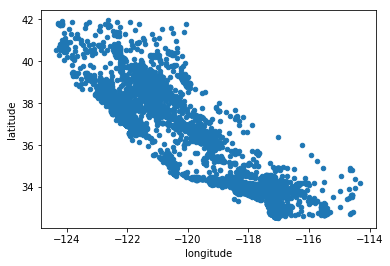

In [40]:
housing.plot(kind='scatter', x='longitude', y='latitude')

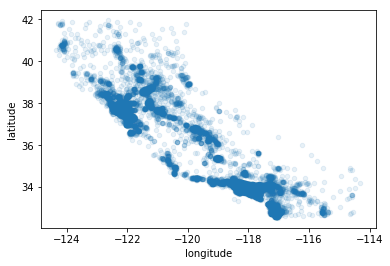

In [41]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

No handles with labels found to put in legend.


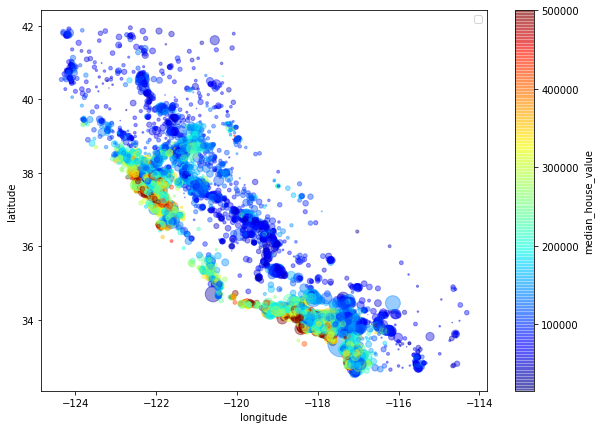

In [47]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/50, figsize=(10, 7), 
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend();

In [50]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

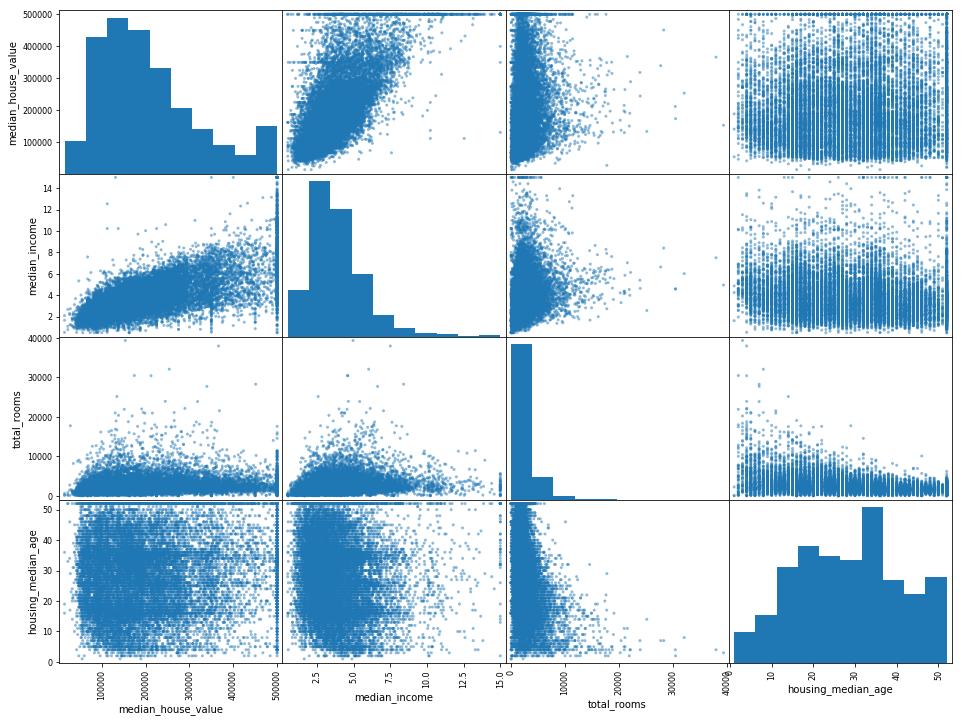

In [53]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(16, 12));

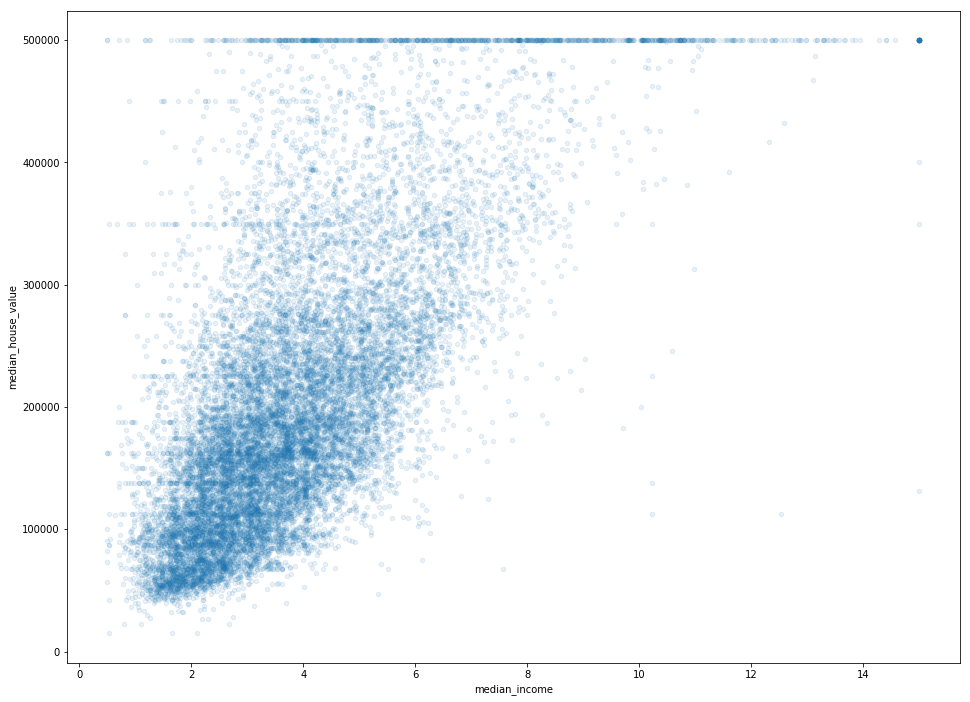

In [55]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(16,12));

In [56]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

In [57]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [58]:
total_bedrooms_median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(total_bedrooms_median, inplace=True)

In [59]:
housing_cat = housing[['ocean_proximity']]

In [61]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [62]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

In [63]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [64]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [65]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [66]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num = housing.drop("ocean_proximity", axis=1)

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [76]:
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num)
cat_attributes = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train a Model

In [79]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [86]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predicitons:', np.round(lin_reg.predict(some_data_prepared), 1))
print('Labels:\t', list(some_labels))

Predicitons: [210644.6 317768.8 210956.4  59219.  189747.6]
Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [87]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848922


In [89]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [90]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [91]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [70019.45942193 66880.55161031 70620.02103915 68909.27226899
 72381.13417555 74525.94517822 69183.68118898 70215.07815913
 75962.59573222 68626.17125695]
Mean: 70732.39100314365
Standard deviation: 2650.4349114333777


In [92]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


In [94]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49427.81505761 47575.94848752 49998.93106576 52444.19680657
 49558.96012542 53431.7555723  48587.20614159 47813.337921
 53045.45982013 50229.87025761]
Mean: 50211.3481255519
Standard deviation: 1995.1803446791198


In [95]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

18688.54124776915


## Fine-Tune Your Model

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [102]:
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format

(pd.DataFrame.from_dict(grid_search.cv_results_))[['mean_test_score', 'mean_train_score', 'param_n_estimators', 
        'param_bootstrap', 'param_max_features', 'std_test_score', 'rank_test_score',  'std_train_score']].sort_values(by=['rank_test_score'])

,mean_test_score,mean_train_score,param_n_estimators,param_bootstrap,param_max_features,std_test_score,rank_test_score,std_train_score
11,-2492720499.3588,-380611189.2005,30,NaN,8,149719626.7832,1,7709372.4075
8,-2517262561.0969,-386351792.5556,30,NaN,6,126769489.4981,2,6165915.7143
5,-2551728079.3003,-392482643.9024,30,NaN,4,145247735.7741,3,4900646.4589
17,-2702339938.1616,0.0000,10,False,4,126518632.9840,4,0.0000
7,-2739578031.1134,-504140189.4000,10,NaN,6,111911631.3705,5,19349997.2039
10,-2762770853.7311,-496195341.5463,10,NaN,8,135825195.0831,6,16729492.5498
15,-2776130129.2830,-0.4421,10,False,3,165021084.1330,7,0.7102
2,-2779922381.7851,-433408925.6792,30,NaN,2,151790891.0557,8,4988048.3874
4,-2801702529.7118,-518876913.3458,10,NaN,4,147866091.1163,9,7217939.7031
13,-2941228628.2043,-1.6685,10,False,2,109376911.4226,10,2.0659


In [103]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [104]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [106]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64473.61777409862 {'max_features': 2, 'n_estimators': 3}
56007.987044460315 {'max_features': 2, 'n_estimators': 10}
52724.96924404132 {'max_features': 2, 'n_estimators': 30}
60173.38816029686 {'max_features': 4, 'n_estimators': 3}
52931.11117019779 {'max_features': 4, 'n_estimators': 10}
50514.63232866608 {'max_features': 4, 'n_estimators': 30}
59428.14784544268 {'max_features': 6, 'n_estimators': 3}
52340.978507412285 {'max_features': 6, 'n_estimators': 10}
50172.328639369676 {'max_features': 6, 'n_estimators': 30}
59049.51515186164 {'max_features': 8, 'n_estimators': 3}
52562.066680555145 {'max_features': 8, 'n_estimators': 10}
49927.15192516746 {'max_features': 8, 'n_estimators': 30}
62253.279004774144 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54233.09532199218 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59358.61590367365 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52688.99438481466 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [107]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.06830258, 0.0662167 , 0.04152989, 0.01625379, 0.01442393,
       0.01509381, 0.01473602, 0.38396213, 0.0603624 , 0.10801936,
       0.04270562, 0.00677228, 0.15692115, 0.00011261, 0.0017198 ,
       0.00286796])

In [108]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38396212723036244, 'median_income'),
 (0.15692115153262037, 'INLAND'),
 (0.10801935738374727, 'pop_per_hhold'),
 (0.06830258179141008, 'longitude'),
 (0.06621669685279558, 'latitude'),
 (0.060362396222440204, 'rooms_per_hhold'),
 (0.04270562426785661, 'bedrooms_per_room'),
 (0.04152988531975909, 'housing_median_age'),
 (0.016253794422890655, 'total_rooms'),
 (0.015093805071362812, 'population'),
 (0.014736015804867499, 'households'),
 (0.014423926748072611, 'total_bedrooms'),
 (0.0067722782765090445, '<1H OCEAN'),
 (0.0028679550203451402, 'NEAR OCEAN'),
 (0.001719797264285574, 'NEAR BAY'),
 (0.00011260679067498196, 'ISLAND')]

In [115]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47942.89125444544

In [118]:
# 95% confidence interval for the generalization error
from scipy import stats
confidence = 0.95

squared_erros = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_erros) - 1, loc=squared_erros.mean(), scale=stats.sem(squared_erros)))

array([45921.27199379, 49882.646503  ])

## Exercises

In [142]:
from sklearn.svm import SVR

param_grid = [
    {'kernel': ['rbf'], 'gamma': [0.001, 100], 'C': [0.01, 100]},
    {'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.01, 100], 'C': [0.01, 100]},
    {'kernel': ['linear'], 'C': [0.001, 100]},
    {'kernel': ['sigmoid'], 'gamma': [0.001, 100], 'C': [0.001, 100]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

KeyboardInterrupt: 

In [132]:
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 46.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f99cf0982e8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f99ceebd080>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

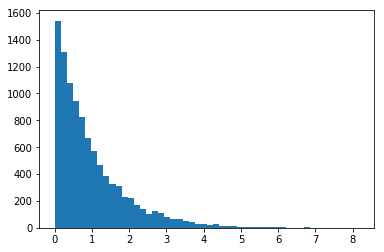

In [133]:
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(expon_distrib, bins=50)
plt.show()

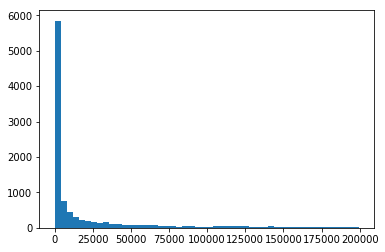

In [134]:
expon_distrib=reciprocal(20, 200000).rvs(10000, random_state=42)
plt.hist(expon_distrib, bins=50)
plt.show()

In [138]:
rmse = np.sqrt(-rnd_search.best_score_)
rmse

54767.99053704409

In [143]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.feature_indices_]

In [144]:
k = 5

top_k_feature_indices = indices_of_top_k(feature_importances, k)
print(top_k_feature_indices)
np.array(attributes)[top_k_feature_indices]

[ 0  1  7  9 12]


array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [145]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.38396212723036244, 'median_income'),
 (0.15692115153262037, 'INLAND'),
 (0.10801935738374727, 'pop_per_hhold'),
 (0.06830258179141008, 'longitude'),
 (0.06621669685279558, 'latitude')]

In [146]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [147]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [148]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [149]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [150]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [151]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print('Predictions:', prepare_select_and_predict_pipeline.predict(some_data))
print('Labels:', list(some_labels))

Predictions: [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels: [286600.0, 340600.0, 196900.0, 46300.0]


In [154]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  17.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  17.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  17.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  17.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  17.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  17.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  17.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  18.1s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  18.1s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  17.8s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  18.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  17.8s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  18.0s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  19.2s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  18.4s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  18.9s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  21.4s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  21.1s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  21.9s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  30.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  35.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  34.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  30.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  32.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  30.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  36.6s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  38.5s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  40.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  38.0s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  39.6s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  36.6s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 144.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [155]:
grid_search_prep.best_params_

{'feature_selection__k': 15, 'preparation__num__imputer__strategy': 'mean'}